In [1]:
import numpy as np
import heapq
import bisect
import math
from typing import Callable, TypeVar
from collections import Counter, deque, defaultdict
import itertools
from intervaltree import Interval, IntervalTree
from functools import cmp_to_key, cache, lru_cache
from concurrent.futures import ThreadPoolExecutor
import networkx as nx
from sortedcontainers import SortedDict

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

T = TypeVar('T')

def data(day: int, parser: Callable[[str], T] = str) -> list[T]:
  with open(f"./data/day{day}.txt") as f:
    return [parser(line.strip()) for line in f.readlines()]

processors = {
  'int_list': lambda x: [int(y) for y in x.split()],
  'int_string': lambda x: [int(y) for y in x]
}

In [47]:
def day1():
    instructions = data(1, lambda x: (x[0], int(x[1:])))
    position, part1, part2 = 50, 0, 0
    for i, v in instructions:
        part2 += v//100
        v = v%100
        current = position + (v if i == 'R' else -v)
        if current >= 100 or (current <= 0 and position):
            part2 += 1
        if not (position := current%100):
            part1 += 1
    return part1, part2

day1()

(1034, 6166)

In [55]:
def day2():
    tree = IntervalTree()
    for x in data(2)[0].split(','):
        start, end = x.split('-')
        tree.addi(int(start), int(end)+1, x)

    cap, tested, part1 = len(str(tree.end()))//2, set(), 0
    for i in range(1, 10**cap):
        point = str(i)*2
        if tree.at(int(point)):
            part1 += int(point)
        tested.add(point)

    part2 = part1
    for i in range(1, 10**cap):
        digits = str(i)
        point = digits*2
        while len(point) < cap*2:
            point += digits
            if point in tested:
                continue
            if tree.at(int(point)):
                part2 += int(point)
            tested.add(point)
    
    return part1, part2

day2()

(40214376723, 50793864718)

In [52]:
def day3():
    jolts = data(3, processors['int_string'])

    def calculate_jolate(n):
        result = 0
        for jolt in jolts:
            index, switches = 0, ''
            for i in range(n, 0, -1):
                relevant = jolt[index:-i+1] or jolt[index:]
                value = max(relevant)
                idx = relevant.index(value)
                index += idx+1
                switches += str(value)
            result += int(switches)
        return result
    
    return calculate_jolate(2), calculate_jolate(12)

day3()

(17263, 170731717900423)

In [3]:
def day4():
    wall = np.pad(np.array(data(4, list)), 1)

    def remove_paper(wall, immediate=False):
        remove = set()
        for i, row in enumerate(np.lib.stride_tricks.sliding_window_view(wall, (3, 3))):
            for j, mask in enumerate(row):
                if mask[1, 1] == '@' and np.count_nonzero(mask=='@') <= 4:
                    if immediate:
                        wall[i+1, j+1] = '.'
                    remove.add((i+1, j+1))
        return remove

    to_remove = remove_paper(wall)
    part1, part2 = len(to_remove), 0
    while to_remove:
        for i, j in to_remove:
            wall[i, j] = '.'
        to_remove = remove_paper(wall, True)
        part2 += len(to_remove)

    return part1, part1+part2

day4()

(1491, 8722)

In [49]:
def day5():
    inventory = data(5)
    separator = inventory.index('')
    ranges = IntervalTree.from_tuples([
        (int(x.split('-')[0]), int(x.split('-')[-1])+1) for x in inventory[:separator]
    ])
    ranges.merge_overlaps()
    ingredients = [int(x) for x in inventory[separator+1:]]

    part1 = sum([bool(ranges.at(i)) for i in ingredients])
    part2 = sum([i.end-i.begin for i in ranges])
    return part1, part2

day5()

(775, 350684792662845)

In [128]:
def day6():
    operations = data(6, lambda x: x.split())
    part1 = sum([
        eval(expr[-1].join(expr[:-1]))
        for expr in zip(*operations)
    ])

    # Only works on solution
    # Does not work on example input
    raw = data(6, list)
    numbers = np.array(raw[:-1]).T
    ops = list(reversed(operations[-1]))
    current, part2 = [], 0
    for i in [''.join(col) for col in numbers] + [' ']:
        if i.strip():
            current.append(i)
        else:
            op = ops.pop()
            part2 += eval(op.join(current))
            current = []

    return part1, part2

day6()

(5060053676136, 9695042567249)

In [4]:
def day7():
    teleports = np.array(data(7, list))
    splits = defaultdict(lambda: [])
    for x in np.argwhere(teleports == '^'):
        heapq.heappush(splits[x[1]], (x[0]))

    splitted = set()
    visited, ends = {}, set()

    start = tuple(np.argwhere(teleports == 'S')[0])
    frontier = [(*start, start)]
    while frontier:
        y, x, source = heapq.heappop(frontier)
        if (y, x) in visited:
            visited[(y, x)] += visited[source]
            continue
        visited[(y, x)] = visited.get(source) or 1

        split = bisect.bisect_left(splits[x], y)
        if split < len(splits[x]):
            newy = splits[x][split]
            splitted.add((newy, x))
            heapq.heappush(frontier, (newy, x-1, (y, x)))
            heapq.heappush(frontier, (newy, x+1, (y, x)))
        else:
            ends.add((y, x))

    return len(splitted), sum(visited[i] for i in ends)

day7()

(1651, 108924003331749)

In [18]:
import math
math.dist((0, 0), (1, 1))

1.4142135623730951

In [33]:
junctions = data(8, lambda x: tuple([int(i) for i in x.split(',')]))
n = 1000

G = nx.Graph()
G.add_nodes_from(junctions)


distances = []
for a, b in itertools.combinations(G.nodes, 2):
    heapq.heappush(distances, (math.dist(a, b), a, b))

for i in range(n):
    d, a, b = heapq.heappop(distances)
    G.add_edge(a, b, length=d)
ccs = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
math.prod(ccs[:3])


75680

In [38]:
junctions = data(8, lambda x: tuple([int(i) for i in x.split(',')]))

G = nx.Graph()
G.add_nodes_from(junctions)


distances = []
for a, b in itertools.combinations(G.nodes, 2):
    heapq.heappush(distances, (math.dist(a, b), a, b))

while not nx.is_connected(G):
    d, a, b = heapq.heappop(distances)
    G.add_edge(a, b, length=d)

print(a[0]*b[0])

25272


40

In [168]:
def day8():
    pass

day8()

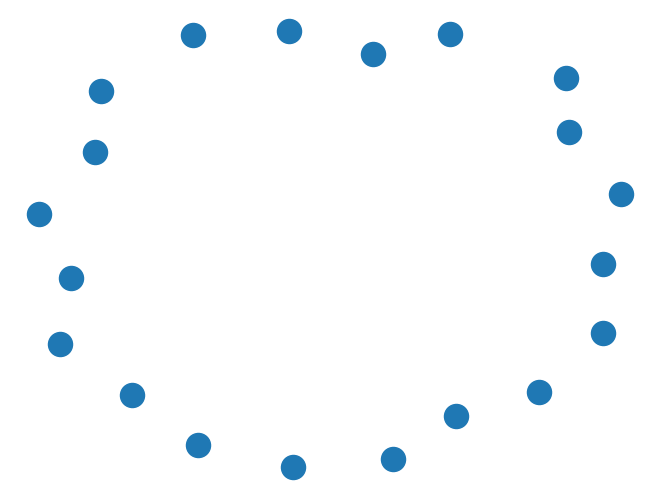

In [19]:
nx.draw(G)